In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
TRAIN = pd.read_csv('gdrive/MyDrive/Colab Notebooks/jigsaw/train_1st_competition.csv')
TEST = pd.read_csv('gdrive/MyDrive/Colab Notebooks/jigsaw/valid_combined.csv', index_col=0)

In [ ]:
EPOCHS = 2
MAX_TOKEN_COUNT = 128
BATCH_SIZE = 32

In [ ]:
pip install transformers

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 61 kB 487 kB/s 
     |████████████████████████████████| 596 kB 58.7 MB/s 
     |████████████████████████████████| 3.3 MB 69.1 MB/s 
     |████████████████████████████████| 895 kB 75.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2

     |████████████████████████████████| 6.9 MB 4.6 MB/s 
     |████████████████████████████████| 776.8 MB 15 kB/s 
     |████████████████████████████████| 816 kB 71.2 MB/s 
     |████████████████████████████████| 829 kB 80.1 MB/s 
     |████████████████████████████████| 132 kB 75.5 MB/s 
     |████████████████████████████████| 1.1 MB 77.9 MB/s 
     |████████████████████████████████| 160 kB 87.2 MB/s 
     |████████████████████████████████| 271 kB 85.4 MB/s 
     |████████████████████████████████| 192 kB 79.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=65b6c32c844ca57837a56fc45bfe032bf33bd41fb36e01fcf1164f6b294457ac
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: f

In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42
Global seed set to 42


42

In [ ]:
TRAIN.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
TRAIN.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
TEST.head()

,id,comment_text
0,0,This article sucks \n\nwoo woo wooooooo
1,1,"""And yes, people should recognize that but the..."
2,2,"Western Media?\n\nYup, because every crime in..."
3,3,And you removed it! You numbskull! I don't car...
4,4,smelly vagina \n\nBluerasberry why don't you ...


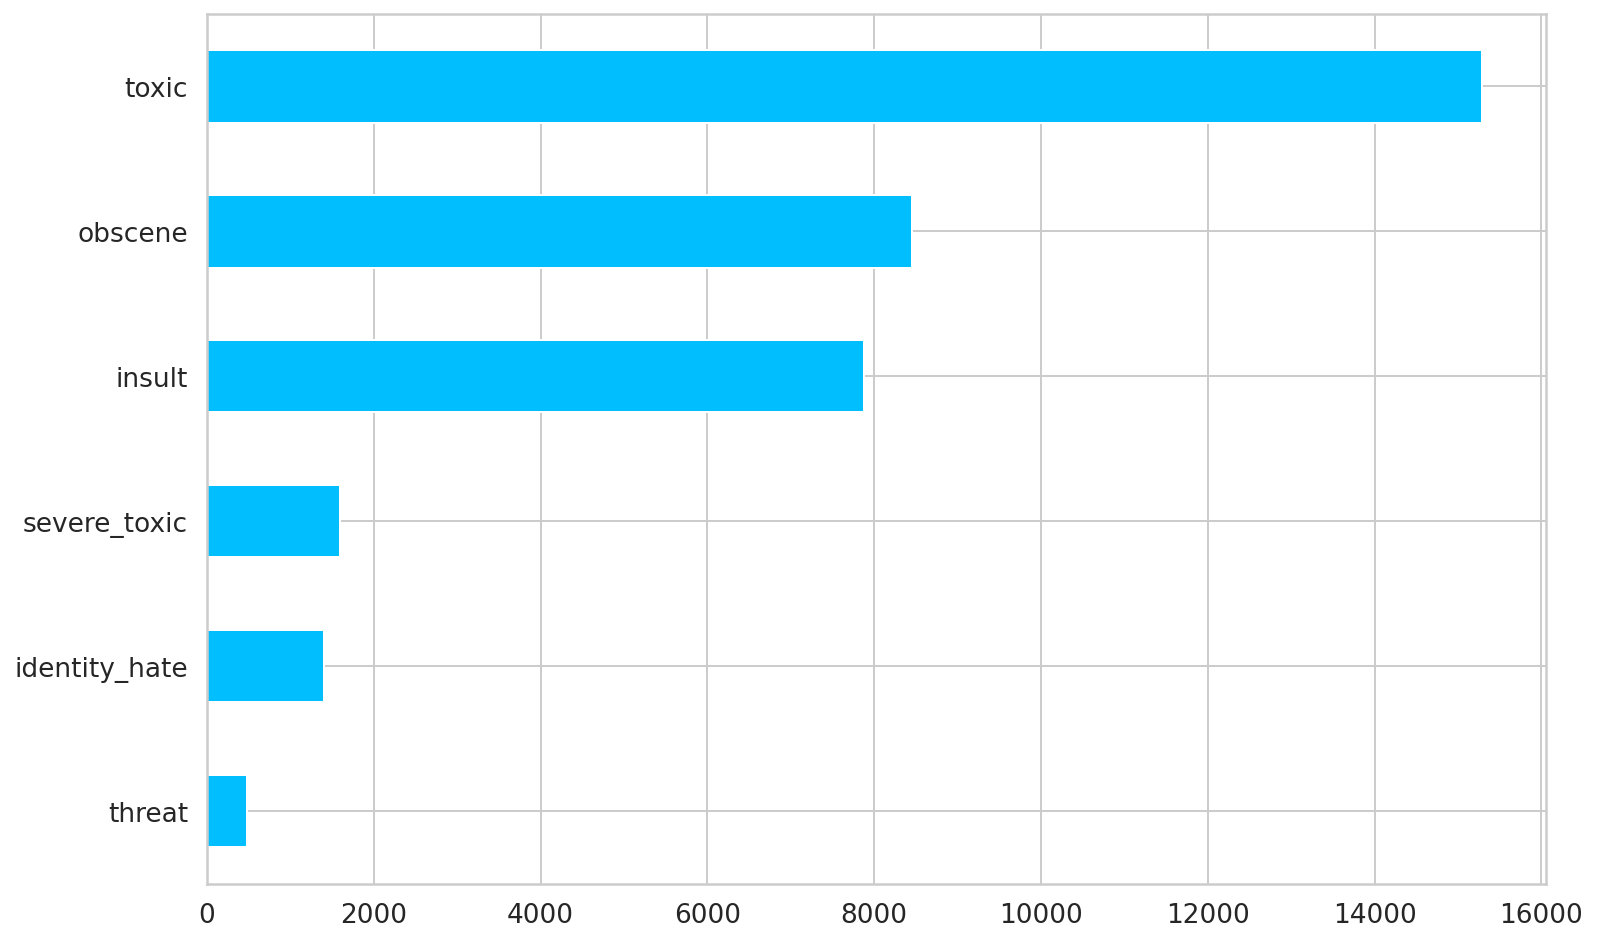

In [ ]:
train_df, val_df = train_test_split(TRAIN, test_size=0.05)

LABEL_COLUMNS = TRAIN.columns.tolist()[2:]
TRAIN[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

((30427, 8), (7979, 8))

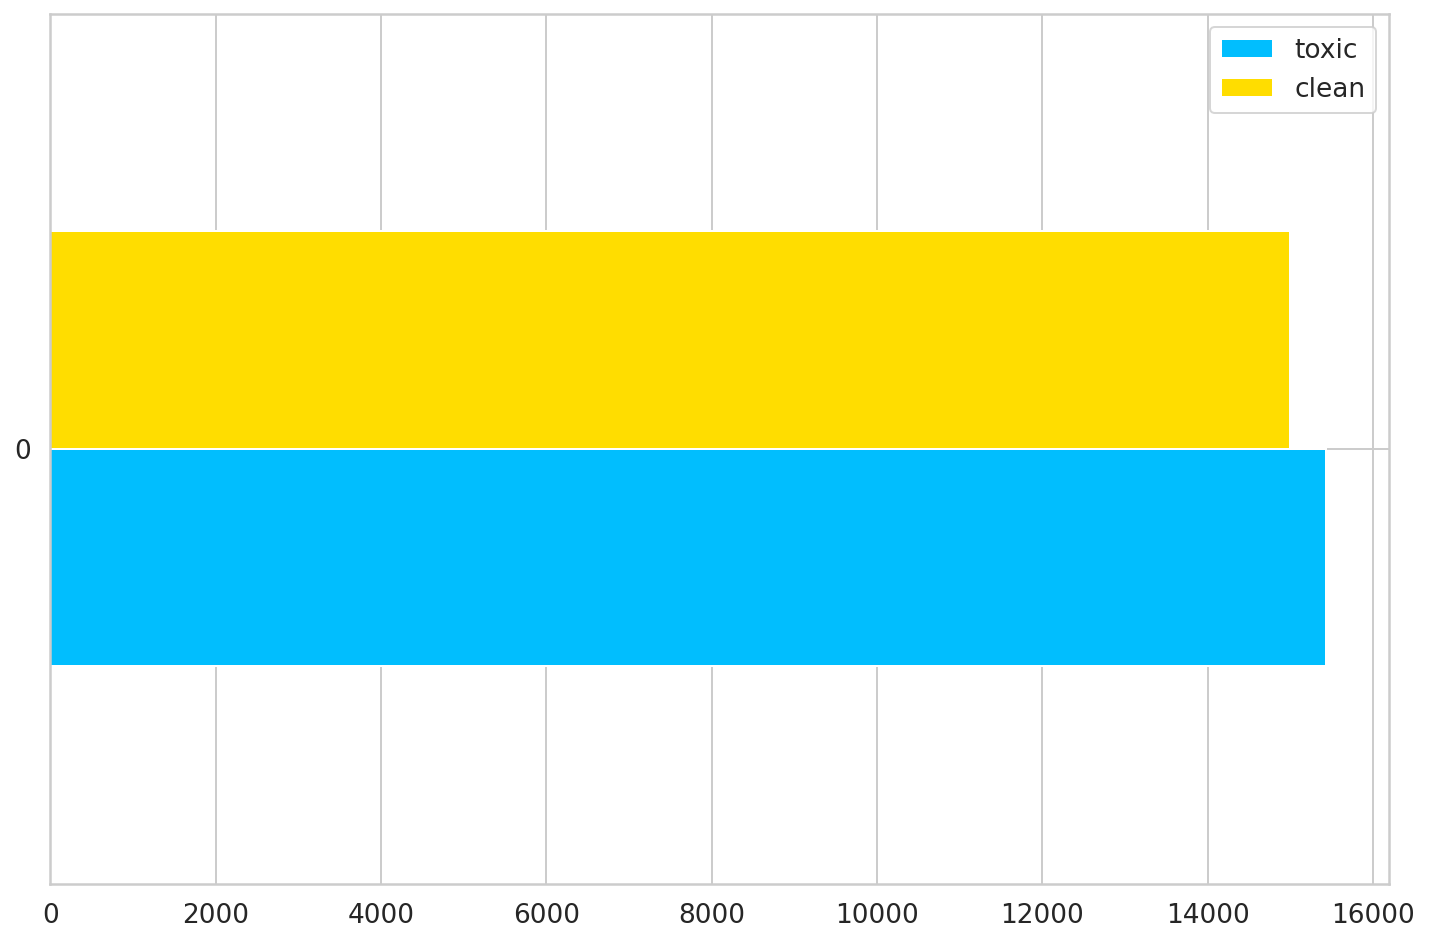

In [ ]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean.sample(15_000))]
)).plot(kind='barh');

#Balanced dataset of toxic and non_toxic comments
train_df = pd.concat([
  train_toxic,
  train_clean.sample(15_000)
])

train_df.shape, val_df.shape

In [ ]:
class ToxicCommentsDataset(Dataset):
    """
    Pass pandas dataframe, and tokeizer along with the max token length[128 default]
    
    Example: 
    -------
    train_dataset = ToxicCommentsDataset(
      train_df,
      tokenizer,
      max_token_len=MAX_TOKEN_COUNT
    )

    sample_item = train_dataset[0]
    
    """
    
    
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = 128,
        test= False
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.test = test
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        _id = data_row['id']
        comment_text = data_row.comment_text
        
        if not self.test:
            labels = data_row[LABEL_COLUMNS]
        
        encoding = self.tokenizer.encode_plus(
            comment_text,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            add_special_tokens=True, # [CLS] & [SEP]
            return_token_type_ids=False,
            return_attention_mask=True, #attention_mask
            return_tensors='pt',
        )
        
        if not self.test:
            return dict(
            _id = _id,
            comment_text=comment_text,
            input_ids = encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels)
        )
        else:
            return dict(
                _id = _id,
                comment_text=comment_text,
                input_ids = encoding["input_ids"].flatten(),
                attention_mask=encoding["attention_mask"].flatten()
            )
        

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

val_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)


In [ ]:
test_dataset = ToxicCommentsDataset(
  TEST,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT,
  test=True
)

In [ ]:
sample_item = train_dataset[0]
print(sample_item.keys())
print(sample_item["_id"])
print(sample_item["comment_text"])
print(sample_item["input_ids"])
print(sample_item["attention_mask"])
print(sample_item["labels"])

dict_keys(['_id', 'comment_text', 'input_ids', 'attention_mask', 'labels'])
1761d05a15926605
Hi, ya fucking idiot. ^_^
tensor([  101,  8790,   117, 11078,  8750, 10696,   119,   167,   168,   167,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,  

In [ ]:
sample_item = val_dataset[0]
print(sample_item.keys())
print(sample_item["_id"])
print(sample_item["comment_text"])
print(sample_item["input_ids"])
print(sample_item["attention_mask"])
print(sample_item["labels"])

dict_keys(['_id', 'comment_text', 'input_ids', 'attention_mask', 'labels'])
7ca72b5b9c688e9e
Geez, are you forgetful!  We've already discussed why Marx  was  not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.'  Ergo, he is a statist - the opposite of an  anarchist.  I know a guy who says that, when he gets old and his teeth fall out, he'll quit eating meat.  Would you call him a vegetarian?
tensor([  101, 23880,  1584,   117,  1132,  1128,  5042,  2365,   106,  1284,
          112,  1396,  1640,  6352,  1725, 13860,  1108,  1136,  1126, 23301,
          117,   178,   119,   174,   119,  1119,  1458,  1106,  1329,   170,
         1426,  1106, 21532,  1117,   112, 11181,  1299,   119,   112,   142,
        17161,   117,  1119,  1110,   170,   188, 19756,  1776,   118,  1103,
         3714,  1104,  1126, 23301,   119,   146,  1221,   170,  2564,  1150,
         1867,  1115,   117,  1165,  1119,  3370,  1385,  1105,  1117,  3307,
         2303,  1149,   117,  1119,

In [ ]:
sample_item = test_dataset[0]
print(sample_item.keys())
print(sample_item["_id"])
print(sample_item["comment_text"])
print(sample_item["input_ids"])
print(sample_item["attention_mask"])
# print(sample_item["labels"])

dict_keys(['_id', 'comment_text', 'input_ids', 'attention_mask'])
0
 This article sucks 

woo woo wooooooo
tensor([  101,  1188,  3342, 22797,   192,  5658,   192,  5658,   192,  5658,
         5658,  5658,  1186,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
len(train_dataloader)

951

In [ ]:
import gc
gc.collect()

5896

In [ ]:
class ToxicCommentTagger(nn.Module):
    
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True) #load the pretrained bert model
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes) # add a linear layer to the bert
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output) 
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = ToxicCommentTagger(len(LABEL_COLUMNS)).to(device)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(bert_model)

ToxicCommentTagger(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
model = bert_model

In [ ]:
N_EPOCHS = EPOCHS


steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(380, 1900)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
)

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  avg_loss = 0
  
  # empty list to save model predictions
  total_preds=[]
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
#     batch = [r.to(device) for r in batch]
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)     

    # clear previously calculated gradients 
    model.zero_grad()        
    loss, outputs = model(input_ids, attention_mask, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()
    scheduler.step()

    # model predictions are stored on GPU. So, push it to CPU
    outputs=outputs.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(outputs)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  print(f"{step}: {avg_loss}")
  

    
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
from sklearn.metrics import roc_auc_score
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  #t0 = time.time()
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []
  total_labels = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)

       # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu

    # batch = [r.to(device) for r in batch]
    
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)   
    
    # deactivate autograd
    with torch.no_grad():
      
      loss, outputs = model(input_ids, attention_mask, labels)

      total_loss = total_loss + loss.item()

      outputs = outputs.detach().cpu().numpy()
      labels = labels.detach().cpu().numpy()
      total_preds.append(outputs)
      total_labels.append(labels)


  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)
  print(f"{step}: {avg_loss}")


  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  total_labels = np.concatenate(total_labels, axis=0)
  true = np.array(total_labels)
  pred = np.array(total_preds>0.5)
  #print(true)
  #print(pred)
  for i, name in enumerate(LABEL_COLUMNS):
      try:
          print(f"{name} roc_auc {roc_auc_score(true[:, i], pred[:, i])}")
      except Exception as e:
        print(e)
        pass
  print(f"Evaluate loss {total_loss / len(val_dataloader)}")
  return avg_loss, total_preds, total_labels

In [ ]:
# The following cell takes 1 hr and 52 mins to run 

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
EPOCHS = 2
#for each epoch
for epoch in range(EPOCHS):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, EPOCHS))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    951.
  Batch   100  of    951.
  Batch   150  of    951.
  Batch   200  of    951.
  Batch   250  of    951.
  Batch   300  of    951.
  Batch   350  of    951.
  Batch   400  of    951.
  Batch   450  of    951.
  Batch   500  of    951.
  Batch   550  of    951.
  Batch   600  of    951.
  Batch   650  of    951.
  Batch   700  of    951.
  Batch   750  of    951.
  Batch   800  of    951.
  Batch   850  of    951.
  Batch   900  of    951.
  Batch   950  of    951.
950: 0.14025246279488476

Evaluating...
  Batch    50  of    250.
  Batch   100  of    250.
  Batch   150  of    250.
  Batch   200  of    250.
249: 0.05404631989076734
toxic roc_auc 0.9391958050491164
severe_toxic roc_auc 0.723101025446259
obscene roc_auc 0.9296515497885238
threat roc_auc 0.576609243129454
insult roc_auc 0.8892070995620777
identity_hate roc_auc 0.738741121488669
Evaluate loss 0.05404631989076734

Training Loss: 0.140
Validation Loss: 0.054

 Epoch 2 / 2
  Batch    50  o

In [ ]:
# function for evaluating the model
def test():
  
  print("\nTesting...")
  # t0 = time.time()
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []
  _ids = []

  # iterate over batches
  for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu


    # batch = [r.to(device) for r in batch]
    _id = batch["_id"]
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    #labels = batch["labels"].to(device)   
    # deactivate autograd
    with torch.no_grad():
      
      loss, outputs = model(input_ids, attention_mask)

      total_loss = total_loss + loss

      outputs = outputs#.detach().cpu().numpy()
      _ids.append(_id)
      total_preds.append(outputs)
    
  # compute the validation loss of the epoch
  avg_loss = total_loss / len(test_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  # _ids  = torch.cat(_ids, axis=0)
  _ids = np.concatenate(_ids, axis=0)
  total_preds  = torch.cat(total_preds, axis=0)
  results = dict(id=_ids,
                 predictions = total_preds
                 )
    

  return avg_loss, total_preds, results

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs#[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
avg_loss, total_preds, total_labels = evaluate()


Evaluating...
  Batch    50  of    250.
  Batch   100  of    250.
  Batch   150  of    250.
  Batch   200  of    250.
249: 0.05404631989076734
toxic roc_auc 0.9391958050491164
severe_toxic roc_auc 0.723101025446259
obscene roc_auc 0.9296515497885238
threat roc_auc 0.576609243129454
insult roc_auc 0.8892070995620777
identity_hate roc_auc 0.738741121488669
Evaluate loss 0.05404631989076734


label: toxic
AUC: 0.9392
Accuracy: 93.11%


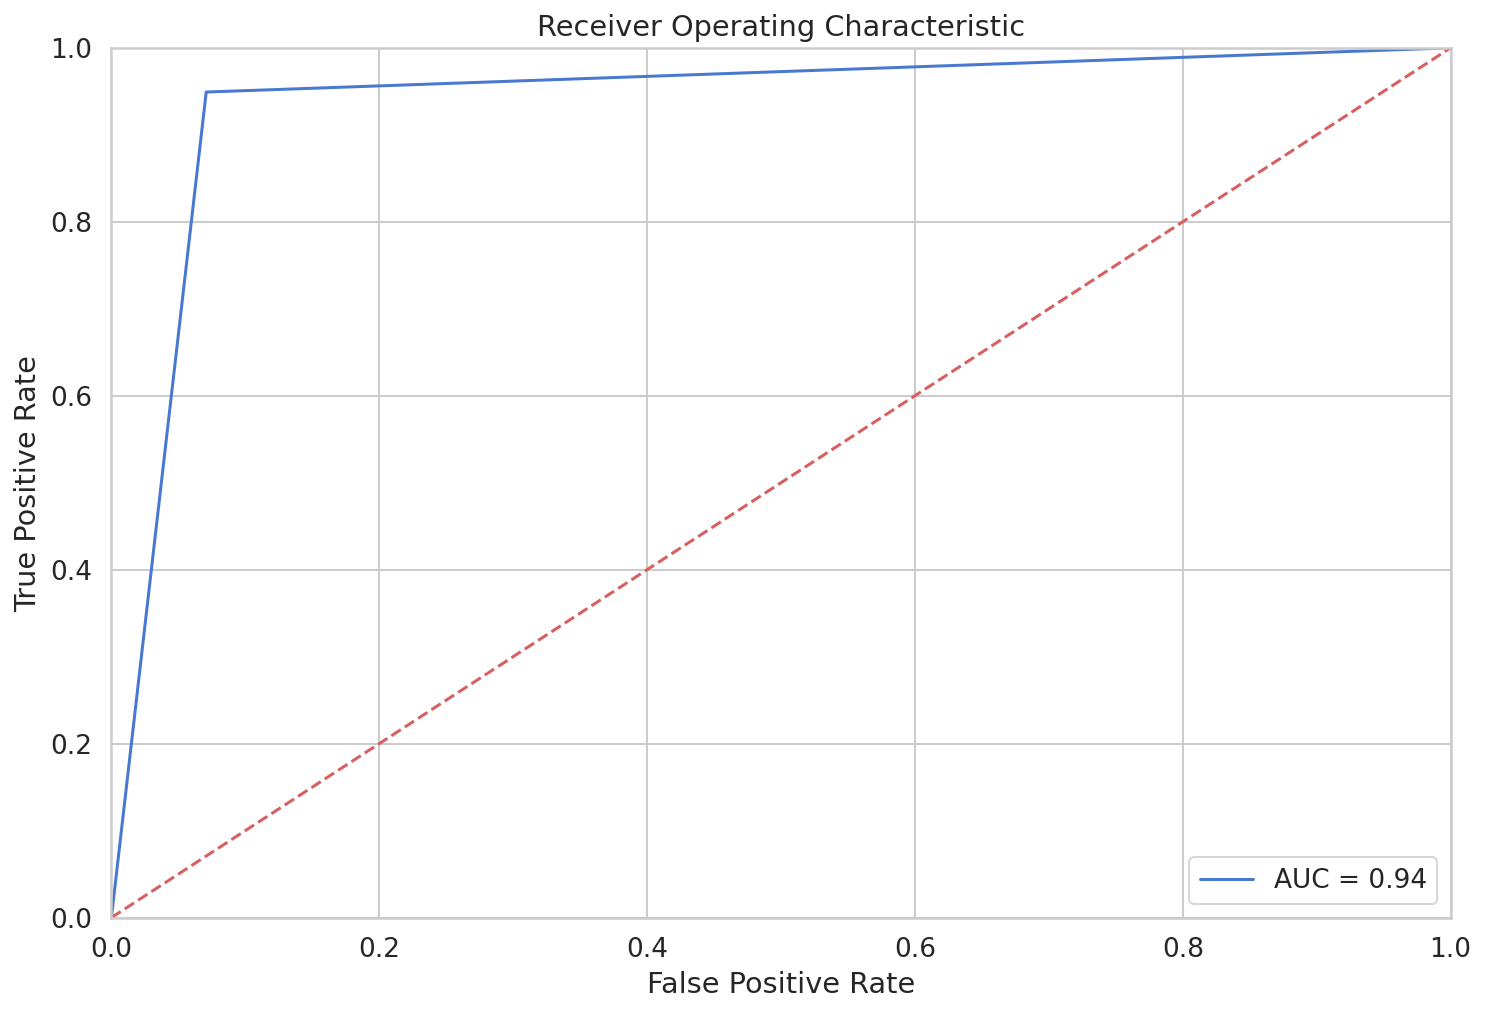

label: severe_toxic
AUC: 0.7231
Accuracy: 99.07%


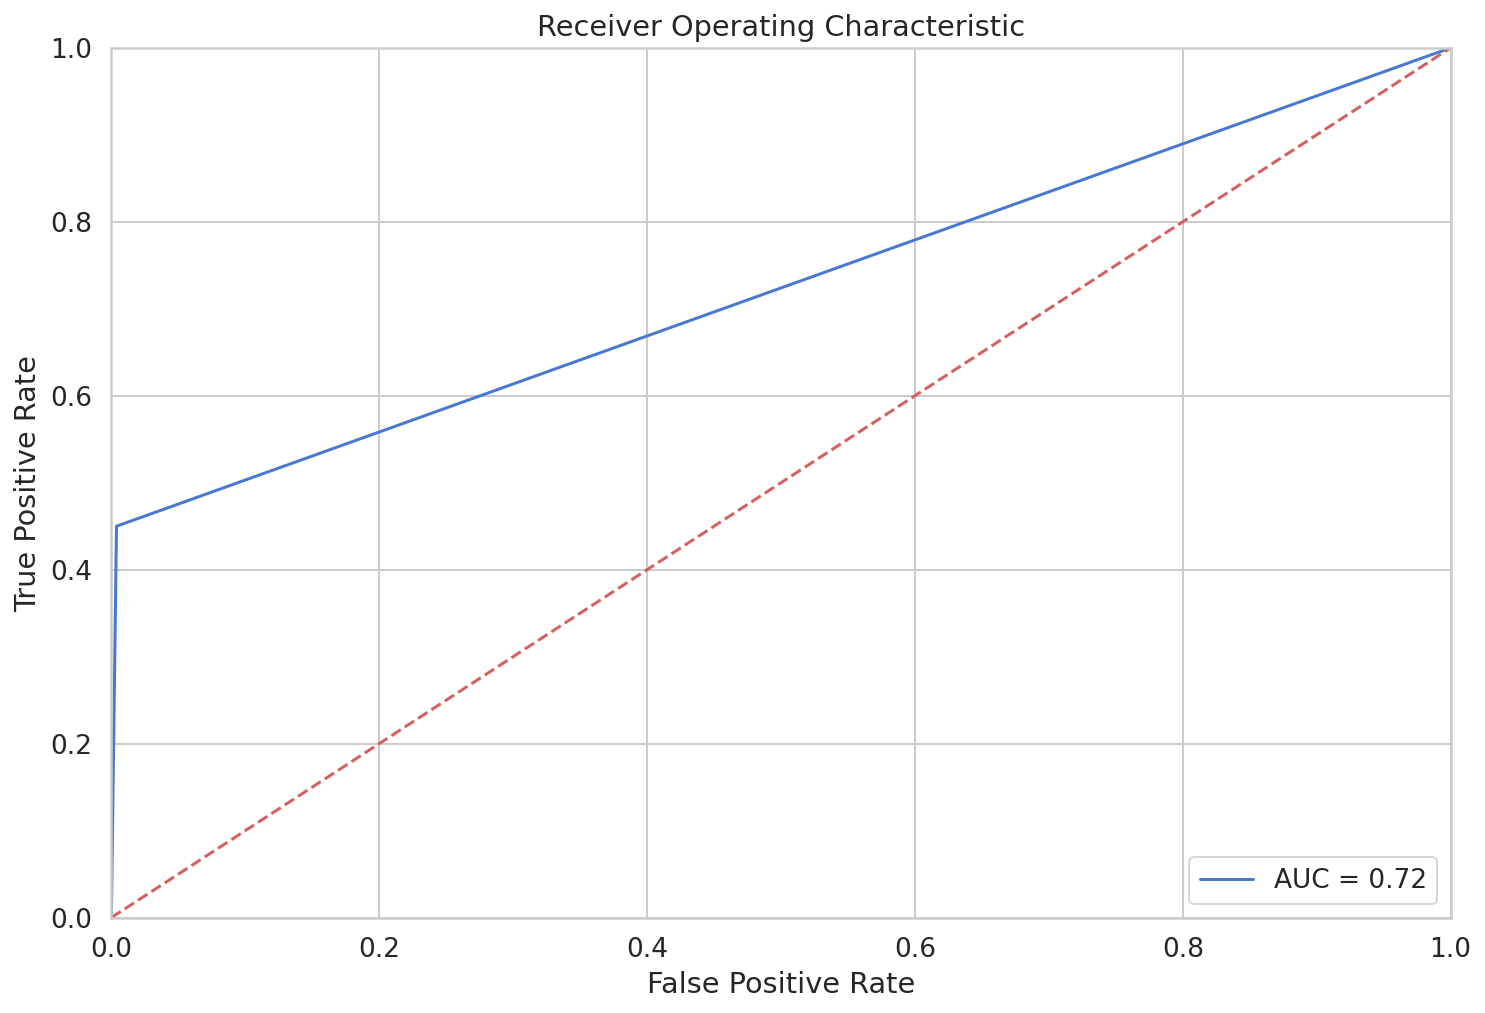

label: obscene
AUC: 0.9297
Accuracy: 98.36%


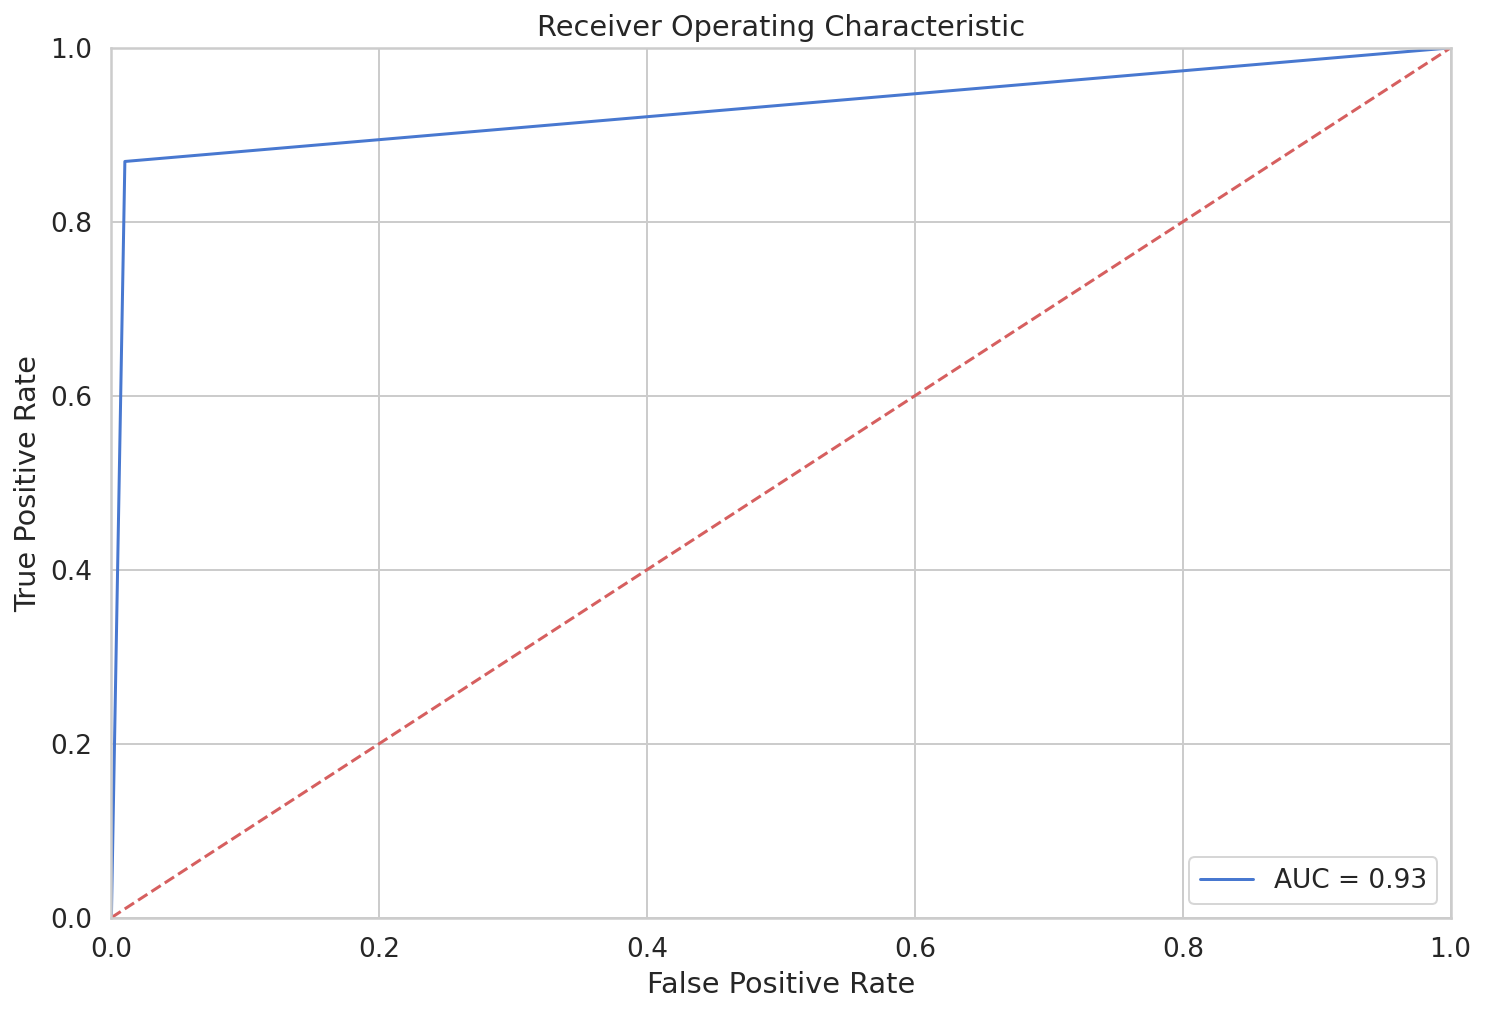

label: threat
AUC: 0.5766
Accuracy: 99.80%


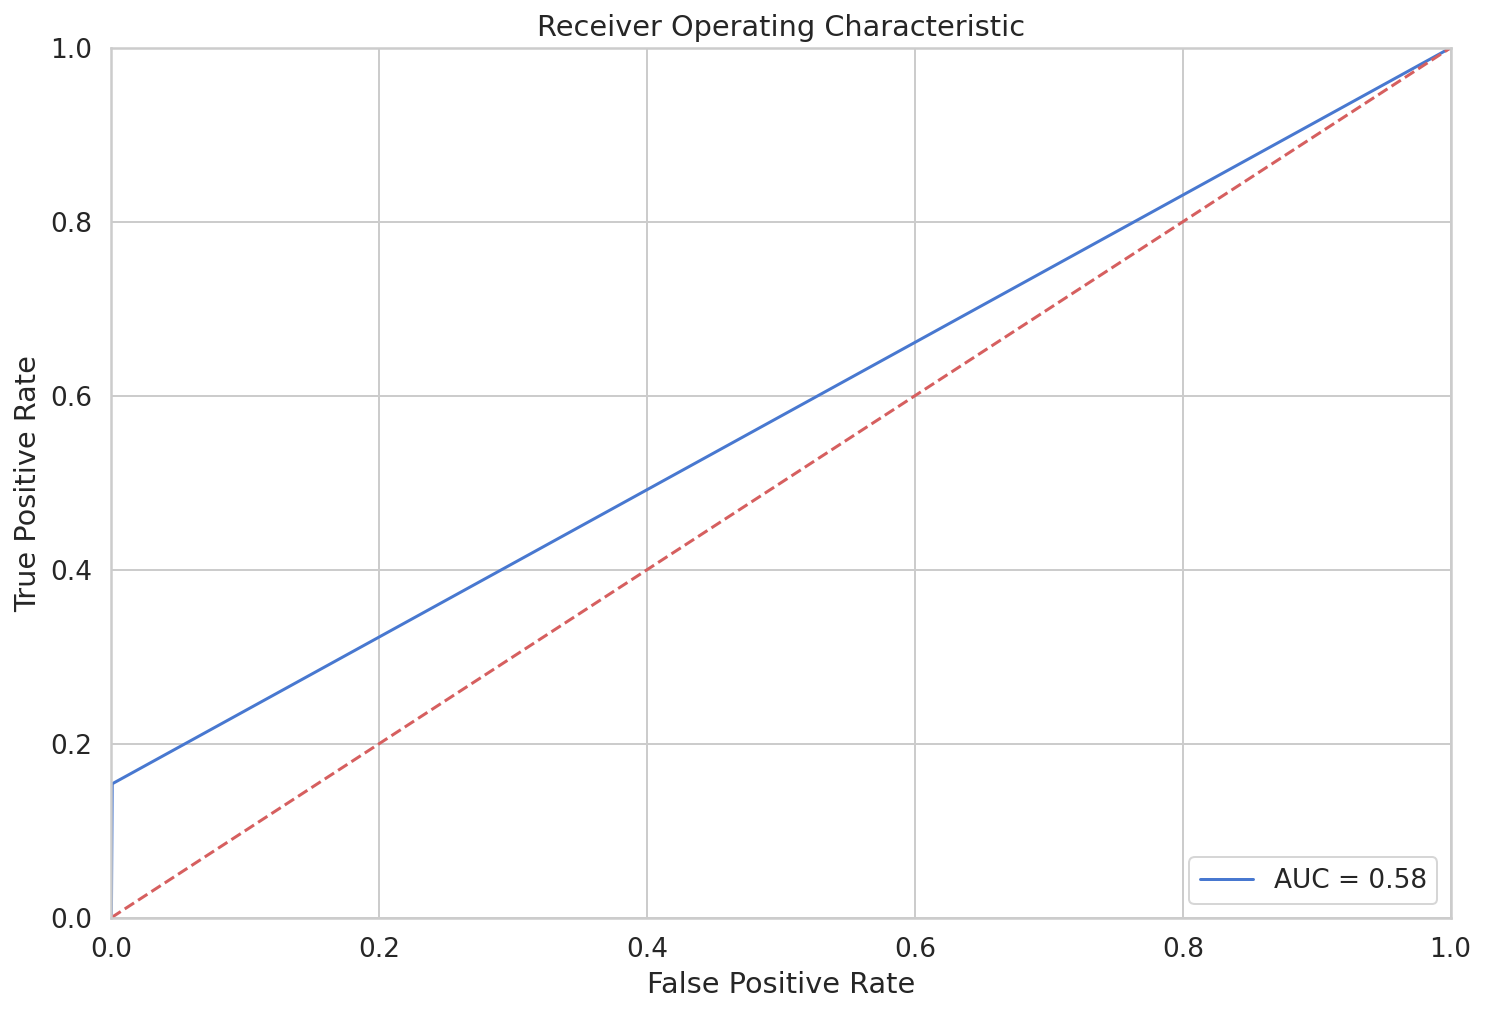

label: insult
AUC: 0.8892
Accuracy: 97.58%


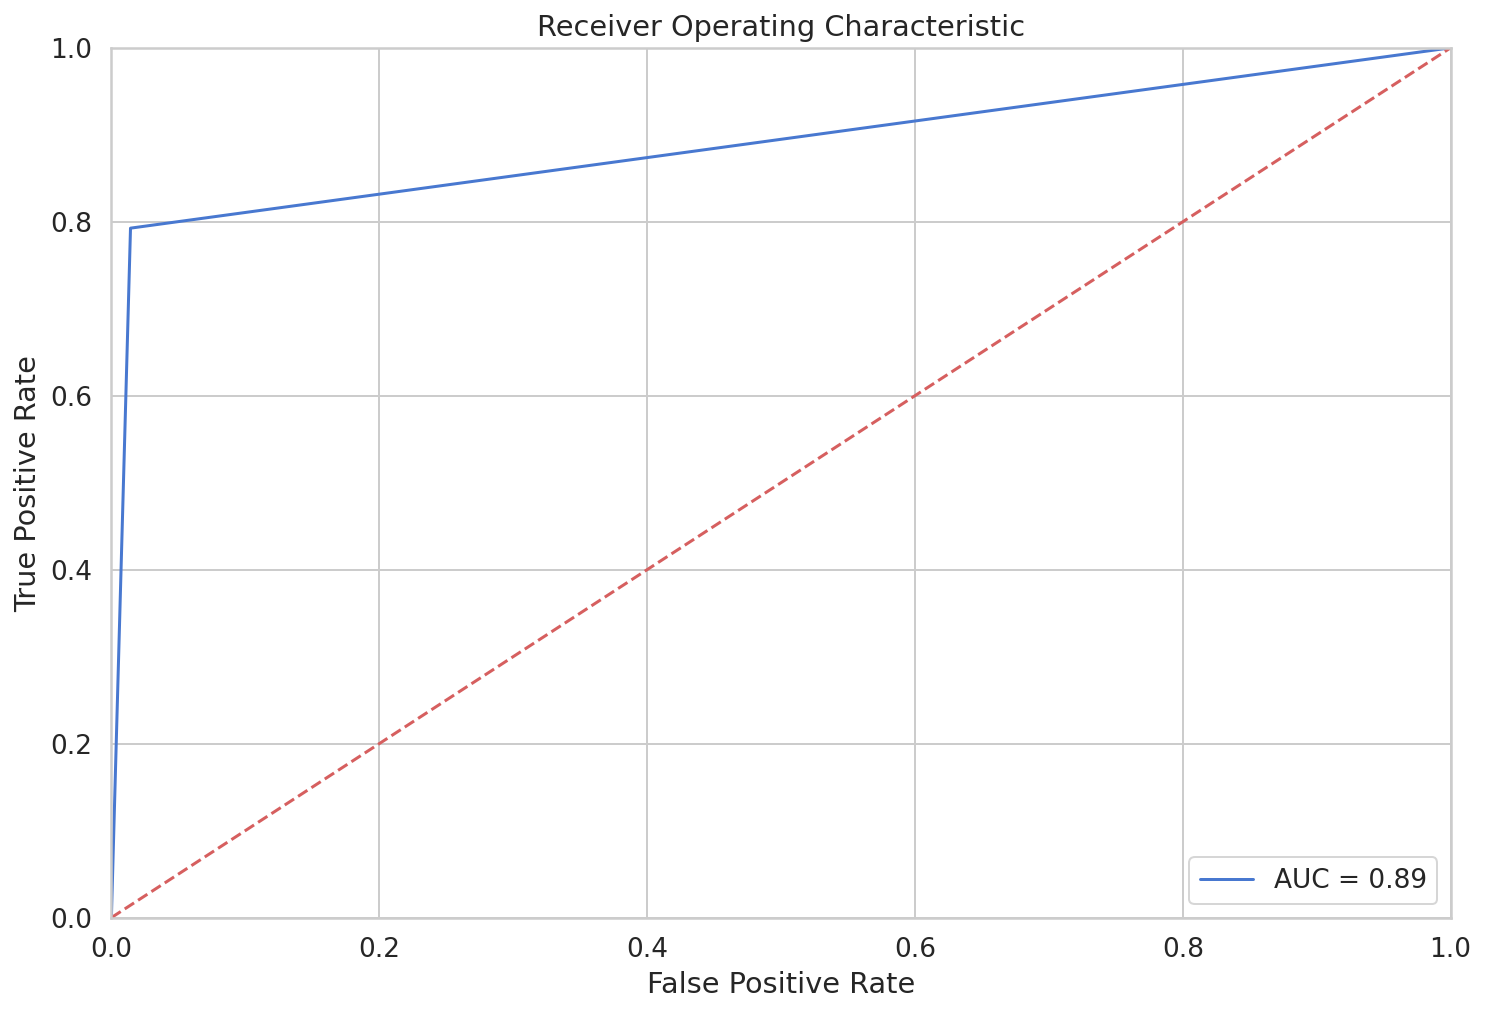

label: identity_hate
AUC: 0.7387
Accuracy: 99.40%


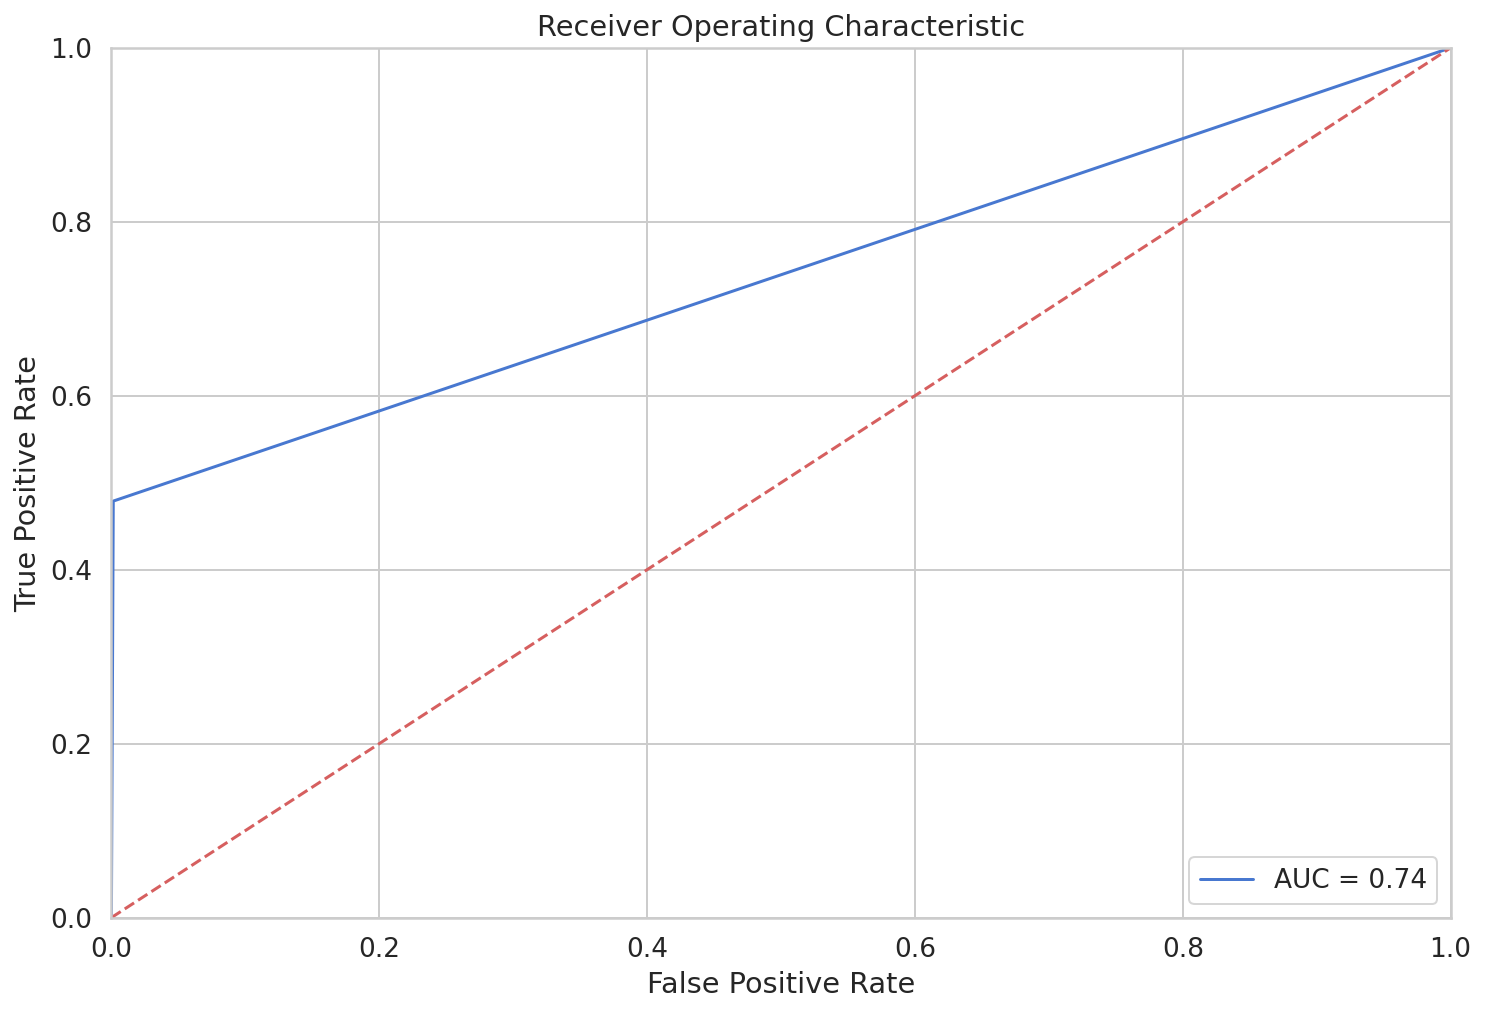

In [ ]:
for i, name in enumerate(LABEL_COLUMNS):
    print(f"label: {name}")
    evaluate_roc(total_preds[:,i]>0.5, total_labels[:,i])

In [ ]:
avg_test_loss, total_test_preds, sub = test()


Testing...
  Batch    50  of  1,882.
  Batch   100  of  1,882.
  Batch   150  of  1,882.
  Batch   200  of  1,882.
  Batch   250  of  1,882.
  Batch   300  of  1,882.
  Batch   350  of  1,882.
  Batch   400  of  1,882.
  Batch   450  of  1,882.
  Batch   500  of  1,882.
  Batch   550  of  1,882.
  Batch   600  of  1,882.
  Batch   650  of  1,882.
  Batch   700  of  1,882.
  Batch   750  of  1,882.
  Batch   800  of  1,882.
  Batch   850  of  1,882.
  Batch   900  of  1,882.
  Batch   950  of  1,882.
  Batch 1,000  of  1,882.
  Batch 1,050  of  1,882.
  Batch 1,100  of  1,882.
  Batch 1,150  of  1,882.
  Batch 1,200  of  1,882.
  Batch 1,250  of  1,882.
  Batch 1,300  of  1,882.
  Batch 1,350  of  1,882.
  Batch 1,400  of  1,882.
  Batch 1,450  of  1,882.
  Batch 1,500  of  1,882.
  Batch 1,550  of  1,882.
  Batch 1,600  of  1,882.
  Batch 1,650  of  1,882.
  Batch 1,700  of  1,882.
  Batch 1,750  of  1,882.
  Batch 1,800  of  1,882.
  Batch 1,850  of  1,882.


In [ ]:
D = pd.DataFrame()
D['id'] = sub['id']
D

,id
0,0
1,1
2,2
3,3
4,4
...,...
60211,60211
60212,60212
60213,60213
60214,60214


In [ ]:
D[LABEL_COLUMNS] = (sub['predictions'].cpu().numpy())
D

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0.979211,0.036279,0.851878,0.004419,0.279385,0.011776
1,1,0.020294,0.002549,0.006284,0.003297,0.006498,0.003401
2,2,0.430808,0.001915,0.011044,0.004015,0.018549,0.015397
3,3,0.969934,0.010026,0.070890,0.035758,0.466163,0.011997
4,4,0.976363,0.017997,0.635038,0.004388,0.274520,0.027265
...,...,...,...,...,...,...,...
60211,60211,0.974542,0.095683,0.912055,0.010177,0.231639,0.014712
60212,60212,0.974542,0.095683,0.912055,0.010177,0.231639,0.014712
60213,60213,0.984870,0.026884,0.733643,0.007201,0.888942,0.048846
60214,60214,0.984870,0.026884,0.733643,0.007201,0.888942,0.048846


In [ ]:
D.to_csv('gdrive/MyDrive/Colab Notebooks/BERT_result.csv', index=False)

In [ ]:
import torch
torch.save(model, 'gdrive/MyDrive/Colab Notebooks/BERT_model')

#saved_model = torch.load('path/to/model')